In [1]:
# Notebook to test batch import of image data and FFTs
# Also test to parallelize scipy rfftn

# This time, write a function that will auto-pad the images with zeroes
# using the s argument

# And transforms over the 1st and 2nd axes

# This will also allow us to average over particle images to recover the reciprocal lattice more easily, I hope

In [2]:
# First, call in 100 test images and stack them.
# Should need ~10 GB of space
# stored in saxtal/rebin_ex100
# added folder to .gitignore

In [2]:
# Import packages

from funcs_mrcio import iwrhdr_opened, irdhdr_opened, iwrsec_opened, irdpas_opened
from funcs_mrcio import irdsec_opened
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as sfft
import time
from skimage.filters import gaussian
from skimage.exposure import rescale_intensity
import pyfftw
import multiprocessing
import os
from tqdm import tqdm
import time

In [3]:
def import_mrc(filename):
    """Use funcs_mrcio to open a specified .mrc file"""
    # Read the .mrc file in binary
    micrograph = open(filename,'rb')
    
    # Use funcs_mrcio to extract image array and rescale values to lie between [-1, 1]
    image = rescale_intensity(irdsec_opened(micrograph,0))
    
    # Use funcs_mrcio to extract header info
    header = irdhdr_opened(micrograph)
    
    # Return the rescaled image and header
    return image, header

In [5]:
arrays = []
# Loop over the filenames in the directory
os.chdir('/home/rkarimi/saxtal/rebin_ex100')
for i in tqdm(os.listdir()):
    image, header = import_mrc(i)
    arrays.append(rescale_intensity(image))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.00it/s]


In [6]:
big_array = np.stack(arrays[:1], axis=-1)

In [7]:
del arrays

In [8]:
# Importing the library
import psutil

# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 60.2
RAM Used (GB): 19.669532672


In [9]:
big_array.shape

(5760, 4092, 75)

In [9]:
# Perform the FFT over the last axis AND zero pad to the right size AND multithread it

# Start the timer
start_time = time.time()

# Perform the FFT
big_array_fft = sfft.rfftn(big_array, 
                           s=(big_array.shape[0], big_array.shape[0]), 
                           axes=(0,1),
                           overwrite_x=True,
                           workers=os.cpu_count())
# Stop the timer
end_time = time.time()
    
print("scipy_fft(): FFT performed in", np.round((end_time-start_time)*1000, 2), "milliseconds.")
print("scipy_fft():", np.round((end_time-start_time)*1000/big_array.shape[2], 2), "milliseconds per image.")

scipy_fft(): FFT performed in 123.75 milliseconds.
scipy_fft(): 123.75 milliseconds per image.


In [10]:
# Get a nice view of the first image and its diffraction spots

fft1 = np.abs(big_array_fft[:,:,0])

In [28]:
fft1

array([[8.5814420e+06, 3.0345218e+06, 1.8638475e+06, ..., 2.3090342e+03,
        8.8280195e+03, 8.5204065e+02],
       [4.4926392e+02, 8.1150775e+02, 1.1109508e+03, ..., 1.7534108e+03,
        2.9729521e+03, 3.0527347e+02],
       [8.1171643e+02, 1.5867706e+03, 5.6611261e+02, ..., 5.4103015e+02,
        1.3527860e+03, 1.1533771e+03],
       ...,
       [7.2833807e+02, 1.0418639e+02, 7.7926794e+02, ..., 8.2918500e+02,
        5.3718109e+02, 6.6178522e+02],
       [8.1171649e+02, 1.3078774e+03, 2.6441879e+02, ..., 5.8515503e+02,
        7.3279388e+02, 1.1533772e+03],
       [4.4926395e+02, 1.1972084e+03, 4.5518640e+02, ..., 1.4570966e+03,
        2.7820029e+03, 3.0527344e+02]], dtype=float32)

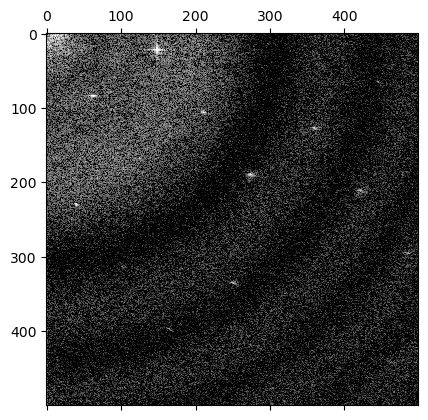

In [23]:
plt.matshow(np.log10(fft1)[:500, :500],
           cmap = "Greys_r",
           vmax = 4,
           vmin = 2.5)

In [40]:
# Get a nice view of the second image

fft2 = np.abs(big_array_fft[:,:,3])

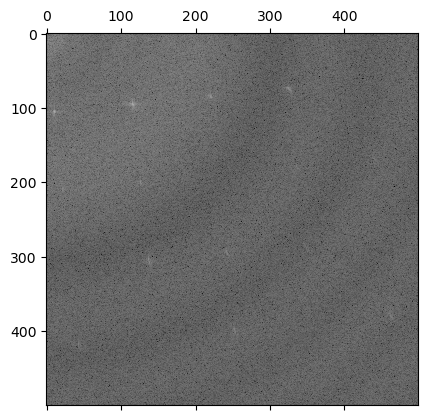

In [41]:
plt.matshow(np.log10(fft2)[:500, :500],
           cmap = "Greys_r",
           vmax = 8,
           vmin = 0)

In [26]:
# Average over the index axis of the array and plot
fft_avg = np.mean(np.abs(big_array_fft), 2)

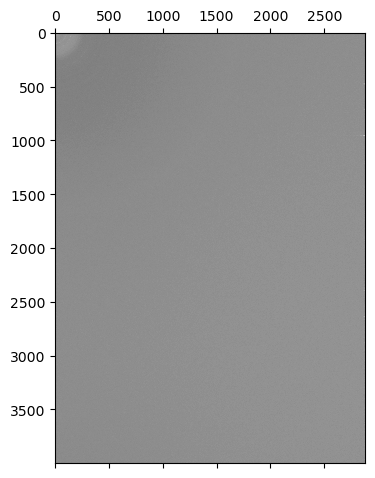

In [49]:
plt.matshow(np.log10(fft_avg)[:4000, :4000],
           cmap = "Greys_r",
           vmax = 6,
           vmin = 0)

In [ ]:
# RESULT: Batching the arrays for an FFT is faster, but the lattice points are different in every image,
# so averaging multiple images averages out the reciprocal lattice.